##### STAGE 02 - EXPLORATORY DATA ANALYSIS AND DATA CLEANING

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb
import datetime as dt
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

###### Loading the datasets

- `We would load both the train and evaluation datasets alongside with the us_metro_data and merged it so as to be able to change the cities with lat and log.`
-  `Also, we would load the holdout_data and perform the same operations done on the training and evaluation dataset especially mapping city with lat and log, removing duplicates, and outliers` 

In [2]:
train_data = pd.read_csv("../data/raw_data/train_data.csv")
eval_data = pd.read_csv("../data/raw_data/eval_data.csv")
holdout_data = pd.read_csv("../data/raw_data/holdout_data.csv")
us_metro_data = pd.read_csv("../data/raw_data/us_metro_data.csv")

print(f"Train data shape: {train_data.shape}")
print(f"Eval data shape: {eval_data.shape}")
print(f"Holdout data shape: {holdout_data.shape}")
print(f"US Metro data shape: {us_metro_data.shape}")

Train data shape: (585244, 39)
Eval data shape: (149424, 39)
Holdout data shape: (149424, 39)
US Metro data shape: (387, 11)


###### Inspecting the training data

In [3]:
train_data["city_full"].value_counts().head()

city_full
New York-Newark-Jersey City       78020
Chicago-Naperville-Elgin          35344
Los Angeles-Long Beach-Anaheim    33840
Philadelphia-Camden-Wilmington    31396
DC_Metro                          29516
Name: count, dtype: int64

In [4]:
print(f"The total number of cities covered: {len(train_data.city_full.value_counts())}")

The total number of cities covered: 30


In [5]:
train_data["city_full"].unique()

array(['Atlanta-Sandy Springs-Alpharetta', 'Pittsburgh',
       'Boston-Cambridge-Newton', 'Tampa-St. Petersburg-Clearwater',
       'Baltimore-Columbia-Towson', 'Portland-Vancouver-Hillsboro',
       'Philadelphia-Camden-Wilmington', 'New York-Newark-Jersey City',
       'Chicago-Naperville-Elgin', 'Orlando-Kissimmee-Sanford',
       'Seattle-Tacoma-Bellevue', 'San Francisco-Oakland-Berkeley',
       'San Diego-Chula Vista-Carlsbad', 'Austin-Round Rock-Georgetown',
       'St. Louis', 'Sacramento-Roseville-Folsom',
       'Phoenix-Mesa-Chandler', 'Riverside-San Bernardino-Ontario',
       'San Antonio-New Braunfels', 'Detroit-Warren-Dearborn',
       'Cincinnati', 'Houston-The Woodlands-Sugar Land',
       'Charlotte-Concord-Gastonia', 'Denver-Aurora-Lakewood',
       'Los Angeles-Long Beach-Anaheim', 'DC_Metro',
       'Dallas-Fort Worth-Arlington', 'Minneapolis-St. Paul-Bloomington',
       'Las Vegas-Henderson-Paradise',
       'Miami-Fort Lauderdale-Pompano Beach'], dtype=object)

###### Inspecting the us_metro_data

In [6]:
us_metro_data.head(2)

,metro_fips,metro,metro_ascii,metro_full,county_name,county_fips,state_id,state_name,lat,lng,population
0,35620,New York,New York,New York-Newark-Jersey City,Suffolk,36103,NY,New York,40.7222,-74.0225,19498249
1,31080,Los Angeles,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles,6037,CA,California,34.2215,-118.1494,12799100


In [7]:
print(f"The total number of cities in the us_metro_data is: {us_metro_data.metro_full.nunique()}")

The total number of cities in the us_metro_data is: 370


###### Extract the cities from both training data and us_metro_data

In [8]:
train_cities = train_data["city_full"].unique().tolist()
metro_cities = us_metro_data["metro_full"].unique().tolist()

##### MAP CITIES WITH LAT/LONG
###### Mapping the cities in training data with the latitude and longitude from the us_metro_data
`- **The one other way to ensure we properly encode the city_full in the training data is to map the city_full with the corresponding lat/long from the us metro data. This way we would have well represented the city using the temporal parameters. We could also leverage on NLP or other form to encode the long-text from the city_full name like the data dictionary.**`

`- **The goal is to use Latitude and Longitude instead of the cities for our ML models and the ensence of downloading the us_metro_data.csv.**`

###### CHECK FOR CITIES IN TRAINING BUT NOT IN THE US_METRO_DATA CITIES

In [9]:
MISSING_CITIES_IN_US_METRO = [item for item in train_cities if item not in metro_cities]
MISSING_CITIES_IN_US_METRO

['Atlanta-Sandy Springs-Alpharetta',
 'San Francisco-Oakland-Berkeley',
 'Austin-Round Rock-Georgetown',
 'Houston-The Woodlands-Sugar Land',
 'Denver-Aurora-Lakewood',
 'DC_Metro',
 'Las Vegas-Henderson-Paradise',
 'Miami-Fort Lauderdale-Pompano Beach']

###### FINDING THE CLOSEST POSSIBLE MATCH FROM US_METRO_DATA CITIES
- We adopt using the Python's built-in `difflib` module, which finds approximate matches for strings and sometimes called `fuzzy`.

In [10]:
import difflib

mapping = {item: difflib.get_close_matches(item, metro_cities, n=1, cutoff=0.6)[0]
           if difflib.get_close_matches(item, metro_cities, n=1, cutoff=0.6)
           else None
           for item in train_cities if item not in metro_cities}

print(mapping)

{'Atlanta-Sandy Springs-Alpharetta': 'Atlanta-Sandy Springs-Roswell', 'San Francisco-Oakland-Berkeley': 'San Francisco-Oakland-Fremont', 'Austin-Round Rock-Georgetown': 'Austin-Round Rock-San Marcos', 'Houston-The Woodlands-Sugar Land': 'Houston-Pasadena-The Woodlands', 'Denver-Aurora-Lakewood': 'Denver-Aurora-Centennial', 'DC_Metro': None, 'Las Vegas-Henderson-Paradise': 'Las Vegas-Henderson-North Las Vegas', 'Miami-Fort Lauderdale-Pompano Beach': 'Miami-Fort Lauderdale-West Palm Beach'}


- ###### `Change 'DC_Metro': None to 'DC_Metro': Washington-Arlington-Alexandria`

In [11]:
city_mapping = {
    'Atlanta-Sandy Springs-Alpharetta': 'Atlanta-Sandy Springs-Roswell', 'San Francisco-Oakland-Berkeley': 'San Francisco-Oakland-Fremont',
    'Austin-Round Rock-Georgetown': 'Austin-Round Rock-San Marcos', 'Houston-The Woodlands-Sugar Land': 'Houston-Pasadena-The Woodlands',
    'Denver-Aurora-Lakewood': 'Denver-Aurora-Centennial', 'DC_Metro': 'Washington-Arlington-Alexandria',
    'Las Vegas-Henderson-Paradise': 'Las Vegas-Henderson-North Las Vegas', 'Miami-Fort Lauderdale-Pompano Beach': 'Miami-Fort Lauderdale-West Palm Beach'
    }

In [12]:
def map_cities_with_lat_long(df: pd.DataFrame) -> pd.DataFrame:
    """This function correct the city names mismatched, merge wit lat/long from us_metro_data"""

    df["city_full"] = df["city_full"].replace(city_mapping)

    df = df.merge(
        us_metro_data[["metro_full", "lat", "lng"]],
        how="left",
        left_on="city_full",
        right_on="metro_full"
    )

    df.drop(columns=["metro_full"], inplace=True)

    # LOGGING ANY CITIES THAT STILL DIDN'T MATCH
    MISSING = df[df["lat"].isnull()]["city_full"].unique()
    if len(MISSING) > 0:
        print("❌The Lat and Long still has some missing data:", MISSING)
    else:
        print("✅All cities matched with the us metro dataset.")

    return df

###### APPLY THE FUNCTION THAT MAP CITIES TO LAT/LONG ON TRAINING, EVALUATION AND HOLDOUT DATASETS

In [13]:
train_df = map_cities_with_lat_long(train_data)
eval_df = map_cities_with_lat_long(eval_data)
holdout_df = map_cities_with_lat_long(holdout_data)

✅All cities matched with the us metro dataset.
✅All cities matched with the us metro dataset.
✅All cities matched with the us metro dataset.


In [14]:
train_df[["city_full", "lat", "lng"]].head()

,city_full,lat,lng
0,Atlanta-Sandy Springs-Roswell,33.7338,-84.3922
1,Pittsburgh,40.4744,-79.8632
2,Pittsburgh,40.4744,-79.8632
3,Pittsburgh,40.4744,-79.8632
4,Pittsburgh,40.4744,-79.8632


In [15]:
print(f"Train data shape after mapping: {train_df.shape}")
print(f"Eval data shape after mapping: {eval_df.shape}")
print(f"Holdout data shape after mapping: {holdout_df.shape}")

Train data shape after mapping: (585244, 41)
Eval data shape after mapping: (149424, 41)
Holdout data shape after mapping: (149424, 41)


###### DATA CLEANING PROCESSES

###### `REMOVING DUPLICATES`

In [16]:
print(f"training df: {train_df.duplicated().sum()}")
print(f"evaluation df: {eval_df.duplicated().sum()}")
print(f"holdout df: {holdout_df.duplicated().sum()}")

training df: 0
evaluation df: 0
holdout df: 0


In [17]:
print(train_df.shape)

duplicated_rows = train_df[train_df.duplicated()].shape[0]
print(f"duplicated rows in training data: {duplicated_rows}")

duplicated_rows = train_df[train_df.duplicated(subset=train_df.columns.difference(["date", "year"]))].shape[0]
print(f"duplicated rows in training data excluding date and year: {duplicated_rows}")



(585244, 41)
duplicated rows in training data: 0
duplicated rows in training data excluding date and year: 6321


In [18]:
# Removing duplicates in training data excluding date and year
train_df = train_df.drop_duplicates(subset=train_df.columns.difference(["date", "year"]), keep=False).reset_index(drop=True)

print(train_df.shape)

duplicated_rows = train_df[train_df.duplicated()].shape[0]
print(f"duplicated rows in training data: {duplicated_rows}")

duplicated_rows = train_df[train_df.duplicated(subset=train_df.columns.difference(["date", "year"]))].shape[0]
print(f"duplicated rows in training data excluding date and year: {duplicated_rows}")


(576860, 41)
duplicated rows in training data: 0
duplicated rows in training data excluding date and year: 0


###### Removing duplicates in the evaluation data

In [19]:
print(eval_df.shape)

duplicated_rows = eval_df[eval_df.duplicated()].shape[0]
print(f"duplicated rows in evaluation data: {duplicated_rows}")

duplicated_rows = eval_df[eval_df.duplicated(subset=eval_df.columns.difference(["date", "year"]))].shape[0]
print(f"duplicated rows in evaluation data excluding date and year: {duplicated_rows}")

(149424, 41)
duplicated rows in evaluation data: 0
duplicated rows in evaluation data excluding date and year: 726


###### Removing duplicates in evaluation data excluding date and year

In [20]:
eval_df = eval_df.drop_duplicates(subset=eval_df.columns.difference(["date", "year"]), keep=False).reset_index(drop=True)

print(eval_df.shape)

duplicated_rows = eval_df[eval_df.duplicated()].shape[0]
print(f"duplicated rows in evaluation data: {duplicated_rows}")

duplicated_rows = eval_df[eval_df.duplicated(subset=eval_df.columns.difference(["date", "year"]))].shape[0]
print(f"duplicated rows in evaluation data excluding date and year: {duplicated_rows}")

(148449, 41)
duplicated rows in evaluation data: 0
duplicated rows in evaluation data excluding date and year: 0


###### Removing duplicates in the holdout dataset

In [21]:
print(holdout_df.shape)

duplicated_rows = holdout_df[holdout_df.duplicated()].shape[0]
print(f"duplicated rows in holdout data: {duplicated_rows}")

duplicated_rows = holdout_df[holdout_df.duplicated(subset=holdout_df.columns.difference(["date", "year"]))].shape[0]
print(f"duplicated rows in holdout data excluding date and year: {duplicated_rows}")

(149424, 41)
duplicated rows in holdout data: 0
duplicated rows in holdout data excluding date and year: 343


In [22]:
holdout_df = holdout_df.drop_duplicates(subset=holdout_df.columns.difference(["date", "year"]), keep=False).reset_index(drop=True)

print(holdout_df.shape)

duplicated_rows = holdout_df[holdout_df.duplicated()].shape[0]
print(f"duplicated rows in holdout data: {duplicated_rows}")

duplicated_rows = holdout_df[holdout_df.duplicated(subset=holdout_df.columns.difference(["date", "year"]))].shape[0]
print(f"duplicated rows in holdout data excluding date and year: {duplicated_rows}")

(148945, 41)
duplicated rows in holdout data: 0
duplicated rows in holdout data excluding date and year: 0


###### OUTLIERS INSPECTION AND CLEANING

In [23]:
print(list(train_df.columns))

['date', 'median_sale_price', 'median_list_price', 'median_ppsf', 'median_list_ppsf', 'homes_sold', 'pending_sales', 'new_listings', 'inventory', 'median_dom', 'avg_sale_to_list', 'sold_above_list', 'off_market_in_two_weeks', 'city', 'zipcode', 'year', 'bank', 'bus', 'hospital', 'mall', 'park', 'restaurant', 'school', 'station', 'supermarket', 'Total Population', 'Median Age', 'Per Capita Income', 'Total Families Below Poverty', 'Total Housing Units', 'Median Rent', 'Median Home Value', 'Total Labor Force', 'Unemployed Population', 'Total School Age Population', 'Total School Enrollment', 'Median Commute Time', 'price', 'city_full', 'lat', 'lng']


In [24]:
train_df.describe()

,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,zipcode,year,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,lat,lng
count,5.768600e+05,5.768600e+05,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,5.768600e+05,576860.000000,576860.000000,576860.000000,576860.000000,576860.000000,5.768600e+05,576860.000000,576860.000000
mean,3.398186e+05,3.734342e+05,195.492727,203.865318,76.846027,82.850704,95.899019,89.936371,69.482995,0.971357,0.213764,0.239979,48788.619648,2015.590322,10.211245,0.531926,4.072118,1.170617,44.987316,48.512728,50.018349,5.803372,8.018594,21707.653236,36.333800,32509.424843,21359.635955,8676.044711,1066.511754,2.863986e+05,11367.528624,931.576565,20885.867866,20885.867866,9705.414220,3.403332e+05,37.823874,-90.921572
std,3.303146e+05,2.318935e+06,845.333573,305.676030,74.879776,84.870395,93.174180,95.920336,84.943758,0.058130,0.164111,0.203565,32400.494084,2.253864,25.352436,1.332775,8.578251,2.617449,74.146273,148.502500,64.026134,16.876455,15.188081,19430.585063,12.275777,19596.991885,19191.799624,7439.300891,488.535828,2.360649e+05,10188.667940,1040.130089,18631.609166,18631.609166,8720.561511,3.016701e+05,5.005930,16.752099
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1431.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.046432e+04,26.157300,-122.478300
25%,1.600000e+05,1.724500e+05,97.321429,103.611111,20.000000,18.000000,26.000000,26.000000,32.000000,0.960167,0.103448,0.037037,19055.000000,2014.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,8.000000,0.000000,0.000000,4857.750000,33.700000,21951.000000,4737.750000,2052.000000,819.000000,1.326000e+05,2494.000000,156.000000,4724.000000,4724.000000,2109.000000,1.665633e+05,34.221500,-98.602300
50%,2.599000e+05,2.760000e+05,141.407736,149.335015,56.000000,58.000000,70.000000,61.000000,52.500000,0.976544,0.186916,0.228346,48035.000000,2016.000000,3.000000,0.000000,1.000000,0.000000,21.000000,9.000000,28.000000,0.000000,3.000000,17880.000000,38.200000,29733.000000,17522.500000,7463.000000,1044.000000,2.292000e+05,9318.000000,614.000000,17285.000000,17285.000000,7949.000000,2.634704e+05,39.081100,-84.464600
75%,4.112500e+05,4.390000e+05,223.417996,234.693477,112.000000,122.000000,138.000000,121.000000,85.000000,0.990143,0.293333,0.380711,78701.000000,2018.000000,10.000000,0.000000,4.000000,1.000000,57.000000,36.000000,68.000000,4.000000,10.000000,33146.000000,42.800000,40698.000000,32613.000000,13440.000000,1333.000000,3.780000e+05,17478.000000,1342.000000,31899.000000,31899.000000,14934.000000,4.156762e+05,40.722200,-76.580700
max,1.550000e+07,1.000000e+09,366700.000000,143015.398551,885.000000,982.000000,1047.000000,1941.000000,7777.000000,1.906250,1.000000,1.000000,98686.000000,2019.000000,416.000000,26.000000,96.000000,45.000000,926.000000,2803.000000,560.000000,192.000000,259.000000,122814.000000,87.200000,465868.000000,122343.000000,48734.000000,3501.000000,2.000001e+06,66704.000000,9735.000000,117632.000000,117632.000000,59316.000000,6.342460e+06,47.557400,-71.100700


###### We would inspect each numerical columns from the dataset to identify the outliers, we would use the `median_list_price` as an example

In [25]:
#fig = px.violin(train_df, y="median_list_price", box=True, hover_name="median_list_price")
#fig.update_layout(title="Violin plot of Median List Price")
#fig.show()


###### We would inspect each numerical columns from the dataset to identify the outliers, we would use the `median_sale_price` as an example

In [26]:
#fig = px.violin(train_df, y="median_sale_price", box=True, hover_name="median_sale_price")
#fig.update_layout(title="Violin plot of Median Sale Price")
#fig.show()

###### We would inspect each numerical columns from the dataset to identify the outliers, we would use the `price` as an example

In [27]:
#fig = px.violin(train_df, y="price", box=True, hover_name="price")
#fig.update_layout(title="Violin plot of Price")
#fig.show()

###### Using the `median_list_price` and observe how many points falls into the outliers - top 1%

In [28]:
top_1_percent = train_df.nlargest(int(0.01 * len(train_df)), "median_list_price")
print(f"Number of points in the top 1% of median_list_price: {top_1_percent.shape[0]}\n")

top_1_percent = train_df.nlargest(int(0.01 * len(train_df)), "median_list_price")
print(top_1_percent["median_list_price"].value_counts().sort_index(ascending=False))

Number of points in the top 1% of median_list_price: 5768

median_list_price
999999999.0      3
50449949.5       3
27800000.0       1
19990000.0      38
15849000.0       1
15624500.0       3
15500000.0       1
13995000.0       1
13100000.0       2
12772000.0       1
12500000.0       5
11900000.0       1
11495000.0       1
10747500.0       1
10692000.0      16
10000000.0       3
9999998.0        1
9934000.0        2
9697500.0        3
9547500.0        1
9394000.0        1
9350000.0        1
9100000.0        1
8900000.0        1
8793944.0        5
8750000.0        3
8700000.0        2
8500000.0        1
8495000.0        1
8142500.0        1
8000000.0        3
7995000.0        1
7988000.0        1
7947500.0        1
7941500.0        1
7750000.0        4
7695000.0        2
7522500.0        1
7495000.0        1
7472500.0        1
7450000.0        1
7442500.0        2
7424000.0        1
7374950.0        1
7300000.0        3
7299500.0        1
7245000.0        1
7199000.0        3
7000000.0  

`We would investigate if the median_list_price outliers are independent in distinct regions, e.g., if DC has different median_list_price and drop outliers to clean the dataset for realistic analysis and results`

In [29]:
train_df = train_df[train_df["median_list_price"] <= 19000000].copy()
eval_df = eval_df[eval_df["median_list_price"] <= 19000000].copy()
holdout_df = holdout_df[holdout_df["median_list_price"] <= 19000000].copy()

In [30]:
#fig = px.violin(train_df, y="median_list_price", box=True, hover_name="median_list_price")
#fig.update_layout(title="Violin plot of Median List Price")
#fig.show()

In [31]:
top_1_percent = train_df.nlargest(int(0.01 * len(train_df)), "median_list_price")
print(top_1_percent["median_list_price"].value_counts().sort_index(ascending=False))

median_list_price
15849000.0      1
15624500.0      3
15500000.0      1
13995000.0      1
13100000.0      2
12772000.0      1
12500000.0      5
11900000.0      1
11495000.0      1
10747500.0      1
10692000.0     16
10000000.0      3
9999998.0       1
9934000.0       2
9697500.0       3
9547500.0       1
9394000.0       1
9350000.0       1
9100000.0       1
8900000.0       1
8793944.0       5
8750000.0       3
8700000.0       2
8500000.0       1
8495000.0       1
8142500.0       1
8000000.0       3
7995000.0       1
7988000.0       1
7947500.0       1
7941500.0       1
7750000.0       4
7695000.0       2
7522500.0       1
7495000.0       1
7472500.0       1
7450000.0       1
7442500.0       2
7424000.0       1
7374950.0       1
7300000.0       3
7299500.0       1
7245000.0       1
7199000.0       3
7000000.0       1
6999500.0       1
6995000.0      31
6945000.0       1
6847500.0       1
6844000.0       2
6822000.0       1
6720000.0       1
6700000.0       1
6665000.0       1
6650000.0 

###### SAVING THE CLEANED DATASETS

In [32]:

train_df.to_csv("../data/processed_data/cleaned_training_data.csv", index=False)
eval_df.to_csv("../data/processed_data/cleaned_evaluation_data.csv", index=False)
holdout_df.to_csv("../data/processed_data/cleaned_holdout_data.csv", index=False)
print("✅ Cleaned Training, evaluation and holdout datasets have been successfully saved.")


✅ Cleaned Training, evaluation and holdout datasets have been successfully saved.


##### DATA EXPLORATION
`Performing the data exploration on the cleaned training datasets`

In [33]:
df = train_df.copy()
df.head(2)

,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,city,zipcode,year,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,lat,lng
0,2012-03-31,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,0.943662,0.142857,0.043478,ATL,30002,2012,12.0,2.0,4.0,1.0,60.0,45.0,57.0,4.0,7.0,5811.0,36.3,33052.0,5811.0,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,200773.999557,Atlanta-Sandy Springs-Roswell,33.7338,-84.3922
1,2012-03-31,200000.0,7500.0,104.931794,79.265873,1.0,1.0,1.0,2.0,290.0,0.909091,0.000000,0.000000,PGH,15469,2012,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2441.0,41.8,20241.0,2385.0,1108.0,641.0,94600.0,1171.0,52.0,2376.0,2376.0,1018.0,105863.681174,Pittsburgh,40.4744,-79.8632


In [34]:
import colorsys as cs
sb.set_theme(style="whitegrid")

###### `Boxplot for house prices for the exploration on the cities, ordered by median price`

Text(0.5, 1.0, 'Boxplot of House Prices for Top 20 Cities (Ordered by Median Price)')

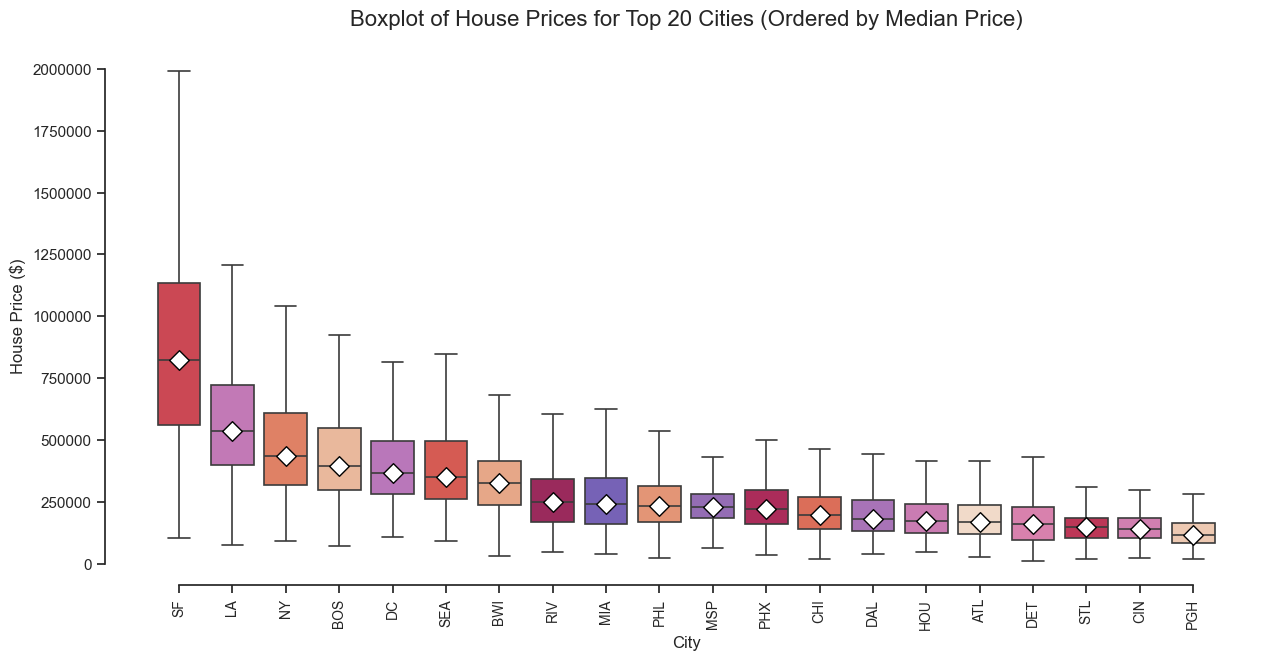

In [35]:
top_cities = df["city"].value_counts().nlargest(20).index.tolist()
df_city = df[df["city"].isin(top_cities)]
city_order = (
    df_city.groupby("city")["price"]
    .median()
    .sort_values(ascending=False)
    .index
)

base = sb.color_palette("rocket_r", n_colors=len(city_order))

def ligthen_color(color, amount=0.5):
    """Lightens the given color by multiplying (1-luminosity) by the given amount.

    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """

    h, l, s = cs.rgb_to_hls(*color)
    return cs.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)

palette = [
    ligthen_color(color, amount=0.5) if i >= len(base) - 8 else color
    for i, color in enumerate(base)
]

sb.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(15, 7))

sb.boxplot(
    data=df_city,
    x="city",
    y="price",
    order=city_order,
    palette=palette,
    ax=ax,
    hue="city",
    showfliers=False,
    linewidth=1.2
)

medians = df_city.groupby("city")["price"].median().loc[city_order].values
for xtick, median in enumerate(medians):
    ax.scatter(xtick, median, color="white", edgecolor="black", zorder=10, s=100, marker="D", label="Median")

ax.set_xlabel("City", fontsize=12)
ax.set_ylabel("House Price ($)", fontsize=12)
ax.tick_params(axis="x", labelrotation=90, labelsize=10)
sb.despine(trim=True)
ax.grid(False)
ax.ticklabel_format(axis="y", style="plain")
ax.set_title("Boxplot of House Prices for Top 20 Cities (Ordered by Median Price)", fontsize=16, pad=15)

C:\Users\Olanrewaju Adegoke\AppData\Local\Temp\ipykernel_27104\3992254574.py:23: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sb.pointplot(


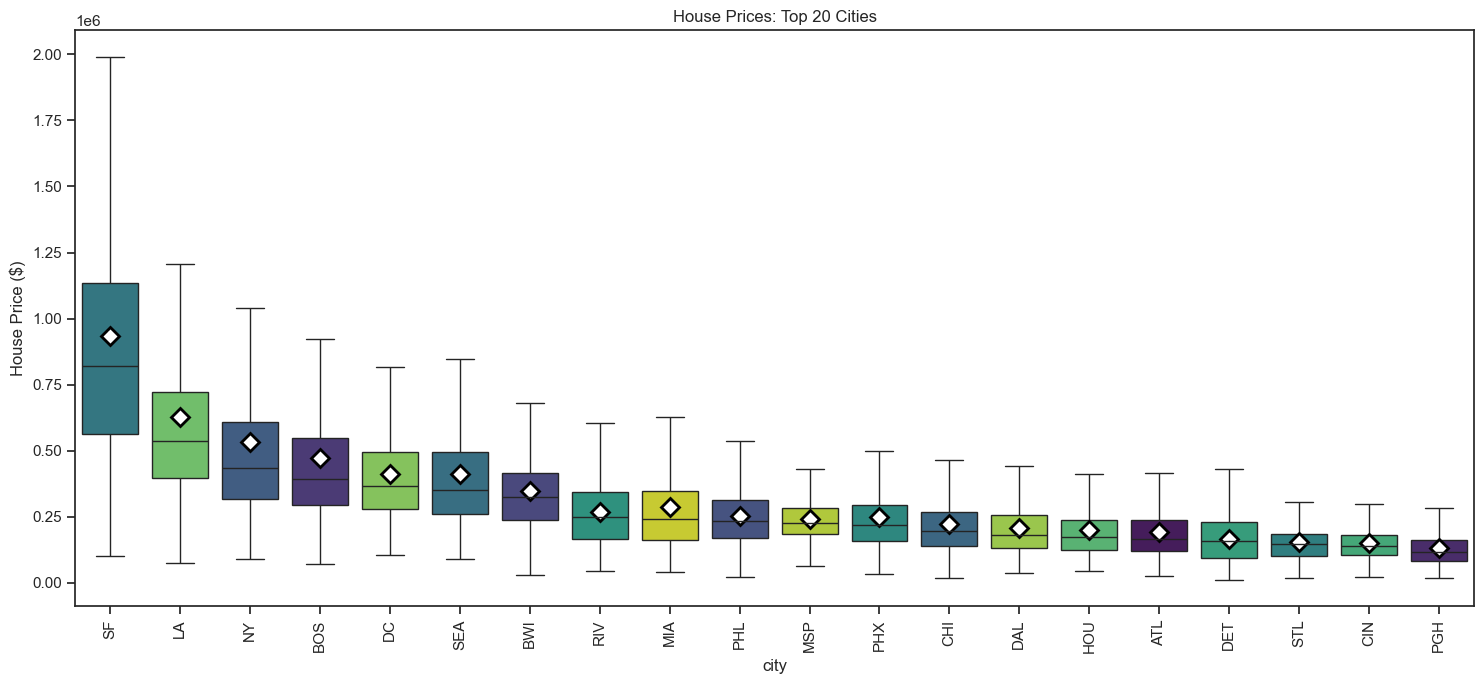

In [36]:
top_cities = df["city"].value_counts().nlargest(20).index
df_city = df[df["city"].isin(top_cities)]

city_order = (
    df_city.groupby("city")["price"]
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(15, 7))
sb.boxplot(
    data=df_city,
    x="city",
    y="price",
    order=city_order,
    palette="viridis",
    hue="city",
    legend=False,
    showfliers=False
)

sb.pointplot(
    data=df_city,
    x="city",
    y="price",
    order=city_order,
    color="white",
    join=False,
    markers="D",
    linestyles="none",
    markersize=9,
    markeredgecolor="black"
)

plt.xticks(rotation=90)
plt.ylabel("House Price ($)")
plt.title("House Prices: Top 20 Cities")
plt.tight_layout()
plt.show()

###### Distribution of House Prices Across The Dataset

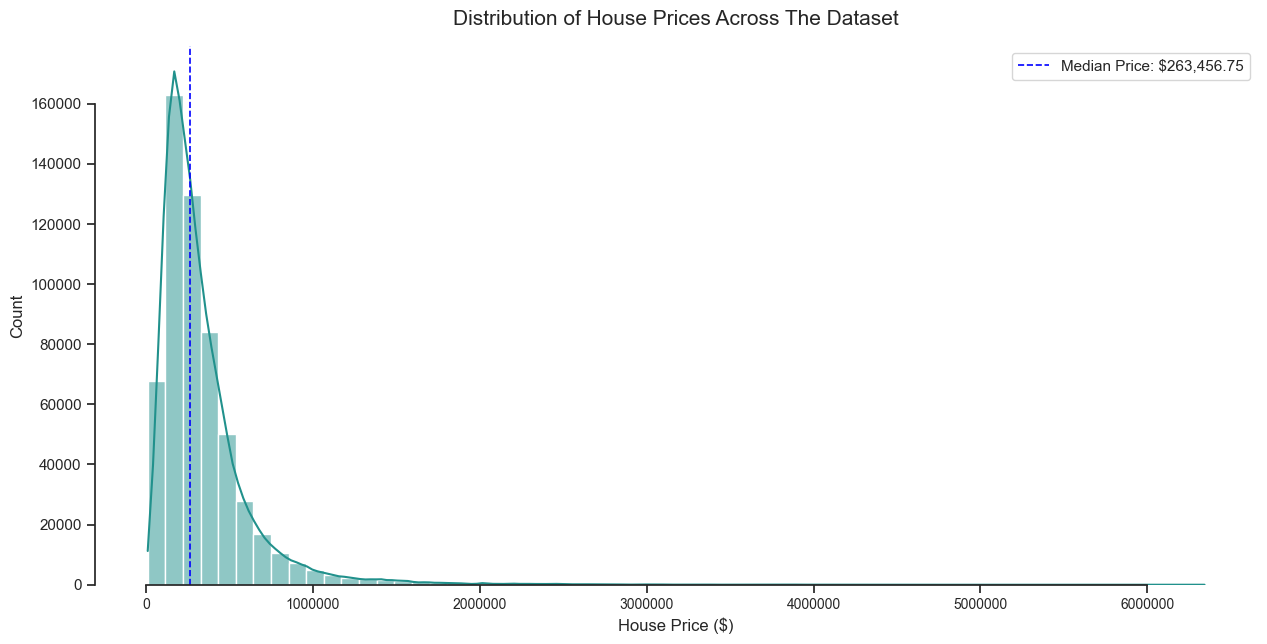

In [37]:
sb.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(15, 7))
sb.histplot(
    data=df["price"].dropna(),
    bins=60,
    kde=True,
    color=sb.color_palette("viridis", n_colors=1)[0],
    ax=ax
)

# median_price = df["price"].median()
# ax.axvline(median_price, color="red", linestyle="--", label=f"Median Price: ${median_price:,.0f}")
# ax.set_xlabel("House Price ($)", fontsize=12)
# ax.set_ylabel("Count", fontsize=12)
# ax.tick_params(axis="x", labelsize=10)
# sb.despine(trim=True)
# ax.grid(False)
# ax.set_title("Distribution of House Prices Across The Dataset", fontsize=16, pad=15)
# ax.legend()
# plt.show()

median_price = df["price"].median()
ax.axvline(median_price, linestyle="--", lw=1.2, color="blue", label=f"Median Price: ${median_price:,.2f}")
ax.set_xlabel("House Price ($)", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.tick_params(axis="x", labelsize=10)
sb.despine(trim=True)
ax.grid(False)
ax.ticklabel_format(axis="x", style="plain")
ax.set_title("Distribution of House Prices Across The Dataset", fontsize=15, pad=15)
ax.legend()
plt.show()

###### Distribution of the Average of the Median List Prices for the House

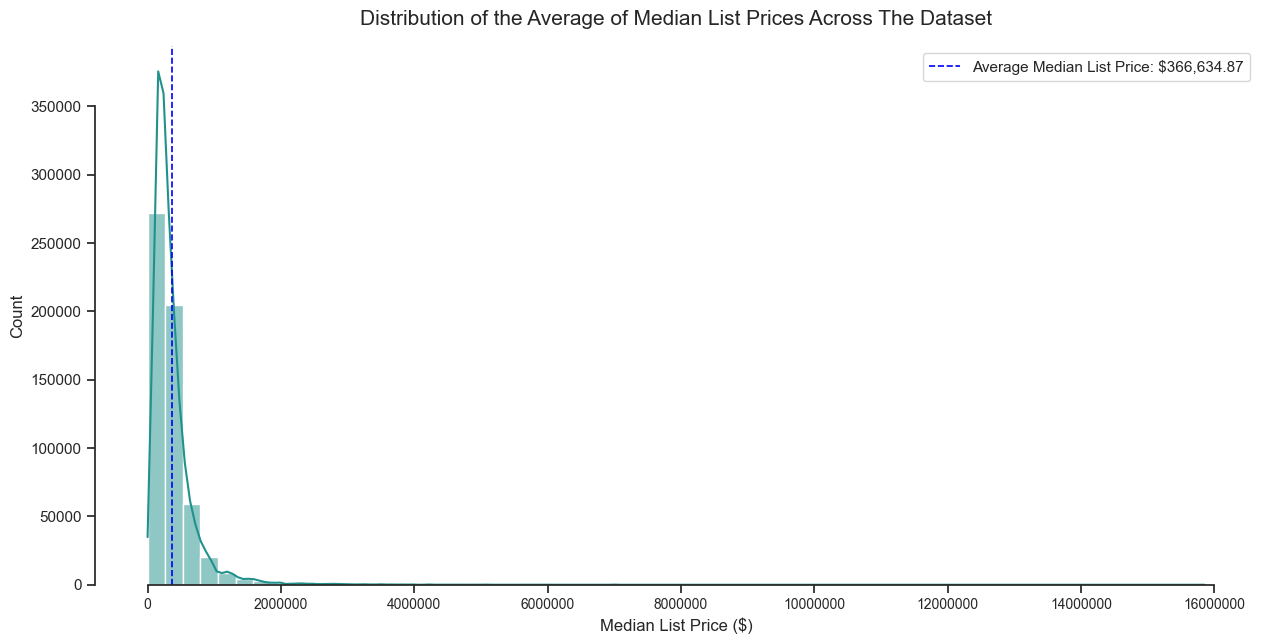

In [38]:
sb.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(15, 7))
sb.histplot(
    data=df["median_list_price"].dropna(),
    bins=60,
    kde=True,
    color=sb.color_palette("viridis", n_colors=1)[0],
    ax=ax
)

average_list_price = df["median_list_price"].mean()
ax.axvline(average_list_price, linestyle="--", lw=1.2, color="blue", label=f"Average Median List Price: ${average_list_price:,.2f}")
ax.set_xlabel("Median List Price ($)", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.tick_params(axis="x", labelsize=10)
sb.despine(trim=True)
ax.grid(False)
ax.ticklabel_format(axis="x", style="plain")
ax.set_title("Distribution of the Average of Median List Prices Across The Dataset", fontsize=15, pad=15)
ax.legend()
plt.show()

###### Distribution of the Average Selling Price for the House

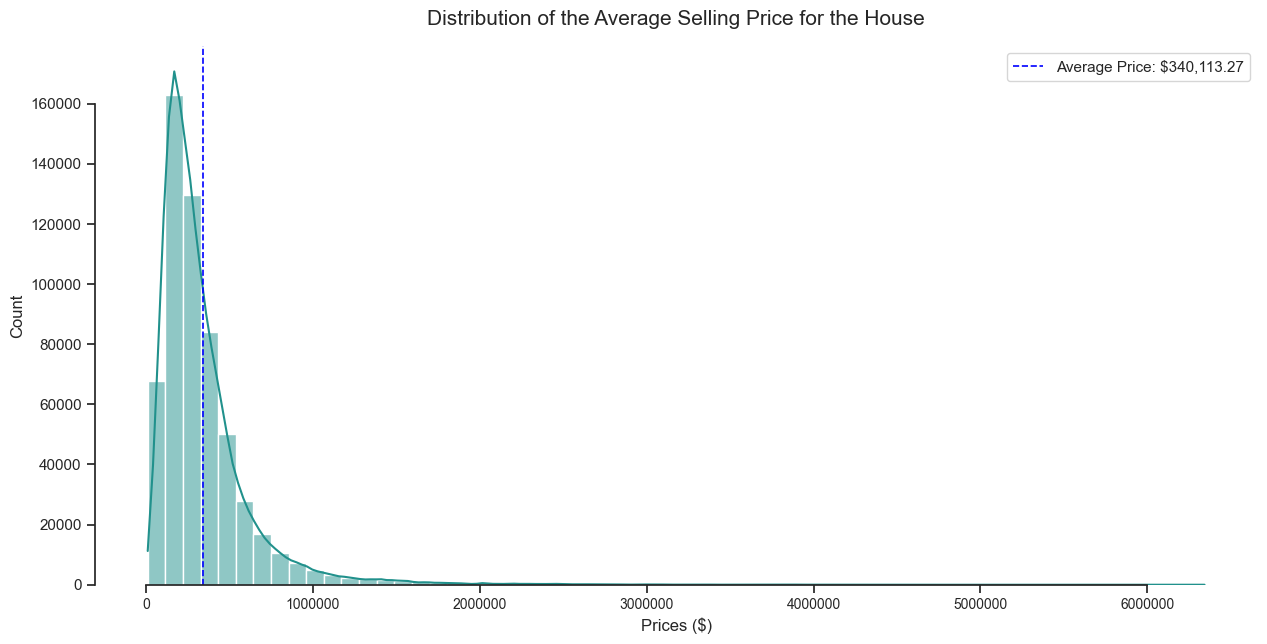

In [39]:
sb.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(15, 7))
sb.histplot(
    data=df["price"].dropna(),
    bins=60,
    kde=True,
    color=sb.color_palette("viridis", n_colors=1)[0],
    ax=ax
)

average_price = df["price"].mean()
ax.axvline(average_price, linestyle="--", lw=1.2, color="blue", label=f"Average Price: ${average_price:,.2f}")
ax.set_xlabel("Prices ($)", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.tick_params(axis="x", labelsize=10)
sb.despine(trim=True)
ax.grid(False)
ax.ticklabel_format(axis="x", style="plain")
ax.set_title("Distribution of the Average Selling Price for the House", fontsize=15, pad=15)
ax.legend()
plt.show()